In [ ]:
from methods import MinibatchSGD, AsynchronousGD, RennalaSGD, WorkerState
from LinearRegression import linear_regression_loss, linear_regression_gradient
from LogisticRegression import logistic_regression_loss, logistic_regression_gradient

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from functools import partial
import scipy.stats as sps

from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LogisticRegression
import scipy.stats as sps
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import ortho_group
from functools import partial
from collections import defaultdict
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**LinReg on diabetes**

In [12]:
from sklearn.datasets import load_diabetes
diabetes_X, diabetes_y = load_diabetes(return_X_y=True)

In [13]:
diabetes_X = np.hstack((diabetes_X, np.ones((len(diabetes_X), 1))))

In [14]:
n_workers = 4
time_distributions = [sps.norm(i+1, scale=1) for i in range(n_workers)]
batch_sizes = np.arange(1, n_workers + 1) * 10


n_iterations = 10000

w = np.zeros(diabetes_X.shape[1])

In [15]:
lr = 0.01

In [6]:
minibatch_sgd = MinibatchSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
async_gd = AsynchronousGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
rennala_sgd = RennalaSGD(w, (diabetes_X, diabetes_y), time_distributions, linear_regression_loss, \
                              [partial(linear_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
rennala_sgd.set_batch_size(5)

methods = {'Minibatch SGD' : minibatch_sgd,
           'Async GD' : async_gd,
           'Rennala SGD' : rennala_sgd}

In [7]:
times = dict()
losses = dict()
for method_name in methods:
    w = np.zeros(diabetes_X.shape[1])
    current_x, loss_history, computation_times, x_history = methods[method_name].run_steps(n_iterations)
    times[method_name] = computation_times
    losses[method_name] = loss_history

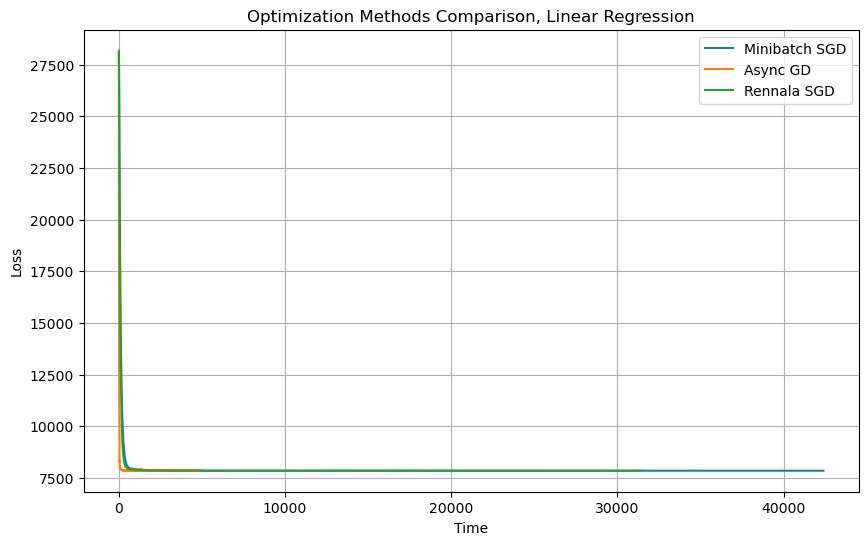

In [8]:
plt.figure(figsize=(10, 6))
for method_name in methods:
    plt.plot(times[method_name], losses[method_name], label=method_name)

plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Optimization Methods Comparison, Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

**LogReg on Mushroom**

In [9]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("prishasawhney/mushroom-dataset")

data = pd.read_csv(f"{path}/mushroom_cleaned.csv")

In [10]:
scaler = MinMaxScaler()

x = data.drop('class', axis=1).values
x = scaler.fit_transform(x)
y = 2*data['class'].values - 1

In [11]:
data_mushroom = (x, y)

In [12]:
lr = 0.01
w = np.zeros(x.shape[1])

In [13]:
minibatch_sgd = MinibatchSGD(w, data_mushroom, time_distributions, logistic_regression_loss, \
                              [partial(logistic_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
async_gd = AsynchronousGD(w, data_mushroom, time_distributions, logistic_regression_loss, \
                              [partial(logistic_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
rennala_sgd = RennalaSGD(w, data_mushroom, time_distributions, logistic_regression_loss, \
                              [partial(logistic_regression_gradient, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
rennala_sgd.set_batch_size(5)

methods = {'Minibatch SGD' : minibatch_sgd,
           'Async GD' : async_gd,
           'Rennala SGD' : rennala_sgd}

In [14]:
times = dict()
losses = dict()
for method_name in methods:
    w = np.zeros(diabetes_X.shape[1])
    current_x, loss_history, computation_times, x_history = methods[method_name].run_steps(1000)
    times[method_name] = computation_times
    losses[method_name] = loss_history

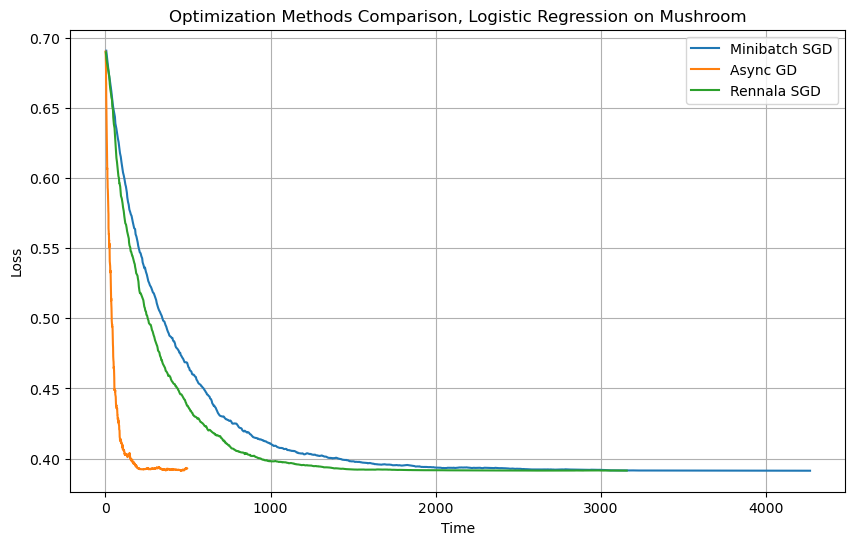

In [15]:
plt.figure(figsize=(10, 6))
for method_name in methods:
    plt.plot(times[method_name], losses[method_name], label=method_name)

plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Optimization Methods Comparison, Logistic Regression on Mushroom')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
np.linalg.norm(logistic_regression_gradient(data_mushroom, x_history[-1]))

0.011560250129488175

**NN on MNIST**

In [40]:
def load_mnist(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0.5, std 0.5
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    return train_dataset, test_dataset

In [41]:
mnist_train, mnist_test = load_mnist()

In [42]:
import MLP_mnist
import importlib
importlib.reload(MLP_mnist)
import methods
importlib.reload(methods)
from methods import MinibatchSGD, AsynchronousGD, RennalaSGD, WorkerState
from MLP_mnist import SimpleNN, loss_from_vector, gradient_from_vector
model = SimpleNN()

In [ ]:
k = 10
subset_indices = torch.randperm(len(mnist_train))[:k]
subset_train = torch.utils.data.Subset(mnist_train, subset_indices)
train_loader = DataLoader(subset_train, batch_size=64, shuffle=True)

In [44]:
criterion = nn.CrossEntropyLoss()

In [45]:
num_param = sum(p.numel() for p in model.parameters())
num_param

12730

In [46]:
start = torch.rand((1, num_param))

In [47]:
minibatch_sgd = MinibatchSGD(start, mnist_train, time_distributions, partial(loss_from_vector, model=model, criterion=criterion), \
                              [partial(gradient_from_vector, model=model, criterion=criterion, batch_size=batch_sizes[i]) for i in range(n_workers)], \
                                  learning_rate=lr)
method_name = 'Minibatch SGD'

In [ ]:
times = dict()
losses = dict()
current_x, loss_history, computation_times, x_history = minibatch_sgd.run_steps(10)
times[method_name] = computation_times
losses[method_name] = loss_history

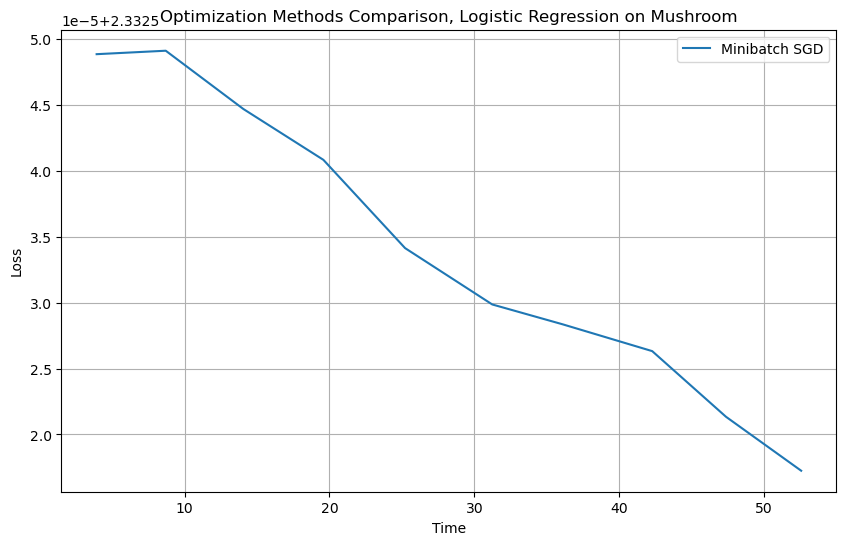

In [50]:
plt.figure(figsize=(10, 6))
methods = ['Minibatch SGD']
for method_name in methods:
    plt.plot(times[method_name], losses[method_name], label=method_name)

plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Optimization Methods Comparison, Logistic Regression on Mushroom')
plt.legend()
plt.grid(True)
plt.show()